<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2023_12_17_three_layer_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilayer Neural Networks Code in PyTorch

## YouTube:
I explained this notebook in a [YouTube video](https://youtu.be/SQfTaOR8ApQ).

## Acknowledgement
I either use concepts or borrowed code from these references:
*   Hart, P. E., Stork, D. G., & Duda, R. O. (2000). Pattern classification. Hoboken: Wiley.
*   [Stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)
*   [PyTorch Tutorials: Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

## Why multilayer neural nets work?
This figure from "Pattern Classification" book shows that neurons in the hidden layer are able to approximate any function.

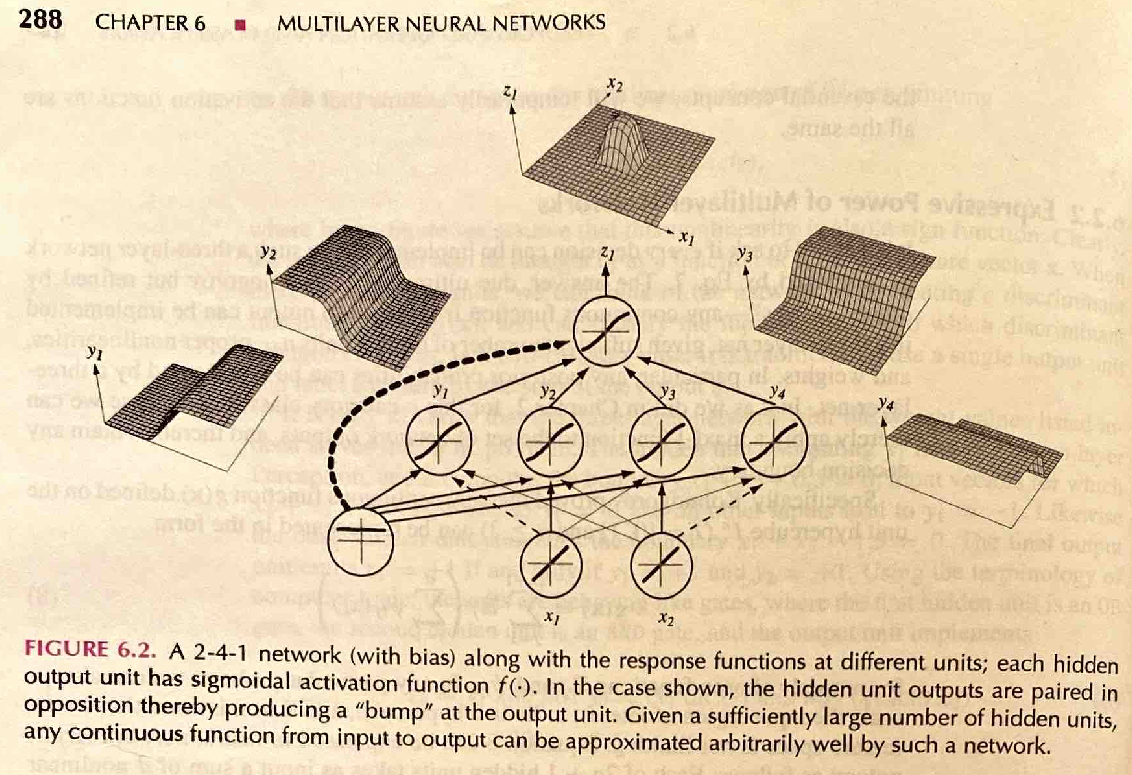

## Why a hidden layer is important?
This figure from "Pattern Classification" book shows that networks with no hidden layer are only able to predict linear decision boundary.

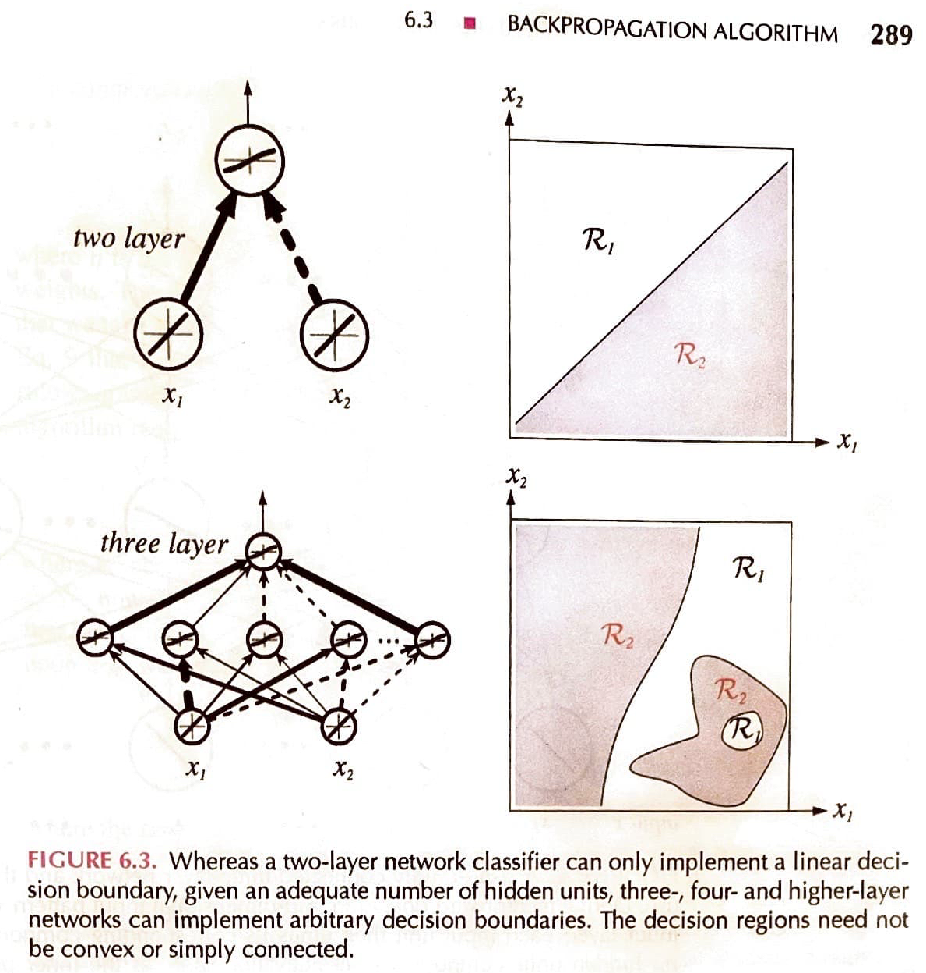

In [ ]:
# Standard libraries
import math
import time
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib import cm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# sklearn
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

random_seed = 42

## Prepare dataset

In [ ]:
X, y = make_blobs(n_samples=200, n_features=2, centers=2, cluster_std=1.9, random_state=random_seed)
X1, y1 = make_circles(n_samples=[600, 200], noise=0.05, factor=0.1, random_state=random_seed)
# increase the radius
X1 = X1*3
# move along the x-axis
X1[:,0] = X1[:,0]+2.5
# move along the y-axis
X1[:,1] = X1[:,1]-7

X = np.concatenate((X, X1), axis=0)
y = np.concatenate((y, y1), axis=0)

In [ ]:
plot_colors = [cm.coolwarm(0),cm.coolwarm(256)]

[Text(0.5, 0, ''), Text(0, 0.5, '')]

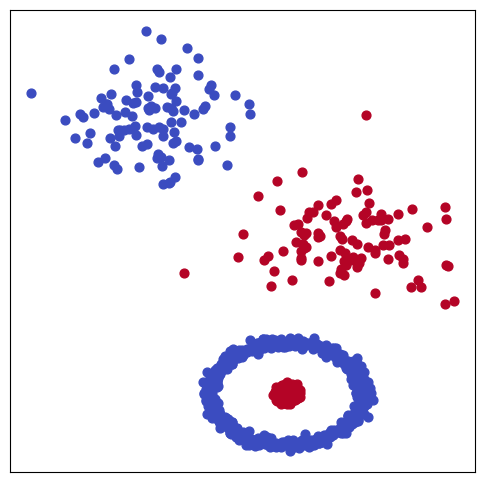

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
for i in np.unique(y):
  ix = np.where(y == i)
  ax.scatter(X[ix,0], X[ix,1], marker='o', s=40, color=plot_colors[i])

ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
ax.set(xlabel=None, ylabel=None)
# plt.savefig('data.png', bbox_inches='tight', dpi=600)

In [ ]:
h = .05  # step size in the mesh
# create a mesh to plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plot_mesh = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()

In [ ]:
# get the train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# convert numpy arrays to torch tensors
X_train_tensor = torch.Tensor(X_train)
X_test_tensor = torch.Tensor(X_test)
y_train_tensor = torch.Tensor(y_train)
y_test_tensor = torch.Tensor(y_test)

# create a torch dataset instance
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# create a torch dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [ ]:
# print the dimension of images to verify all loaders have the same dimensions
def print_dim(loader, text):
  print('---------'+text+'---------')
  print(len(loader.dataset))
  for image, label in loader:
    print(image.shape)
    print(label.shape)
    break

print_dim(train_loader,'train loader')
print_dim(test_loader,'test loader')

---------train loader---------
800
torch.Size([32, 2])
torch.Size([32])
---------test loader---------
200
torch.Size([32, 2])
torch.Size([32])


## Train the model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)

In [ ]:
def make_predictions(model, points_to_predict):
  # evaluate all the points in plot_mesh
  model.eval()
  with torch.inference_mode():
    y_logits = model(plot_mesh)

  # turn logits to predictions
  y_pred = torch.round(torch.sigmoid(y_logits))
  y_pred = y_pred.reshape(xx.shape).detach().numpy()
  return y_pred

In [ ]:
predictions = []
for epoch in range(2000):  # loop over the dataset multiple times
  model.train()
  for i, data in enumerate(train_loader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data


      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels.unsqueeze(1))
      loss.backward()
      optimizer.step()

  # print statistics
  if epoch % 100 == 0:
    print(f'Epoch {epoch:>3} | loss: {loss.item():.4f}')
    predictions.append(make_predictions(model,plot_mesh))

print('Finished Training')

Epoch   0 | loss: 0.3248
Epoch 100 | loss: 0.1826
Epoch 200 | loss: 0.1202
Epoch 300 | loss: 0.2084
Epoch 400 | loss: 0.0548
Epoch 500 | loss: 0.0903
Epoch 600 | loss: 0.0158
Epoch 700 | loss: 0.0105
Epoch 800 | loss: 0.0068
Epoch 900 | loss: 0.0060
Epoch 1000 | loss: 0.0081
Epoch 1100 | loss: 0.0044
Epoch 1200 | loss: 0.0050
Epoch 1300 | loss: 0.0056
Epoch 1400 | loss: 0.0092
Epoch 1500 | loss: 0.0058
Epoch 1600 | loss: 0.0099
Epoch 1700 | loss: 0.0239
Epoch 1800 | loss: 0.0088
Epoch 1900 | loss: 0.0076
Finished Training


## Plotting decision boundary

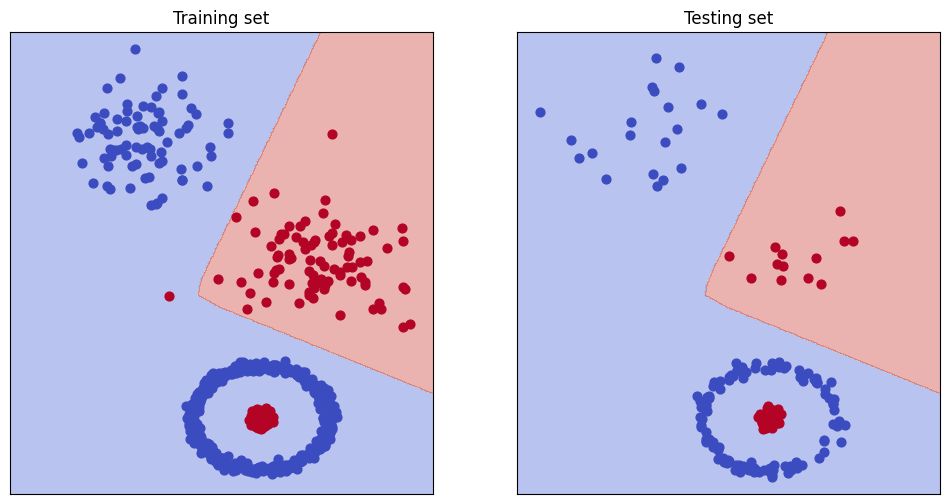

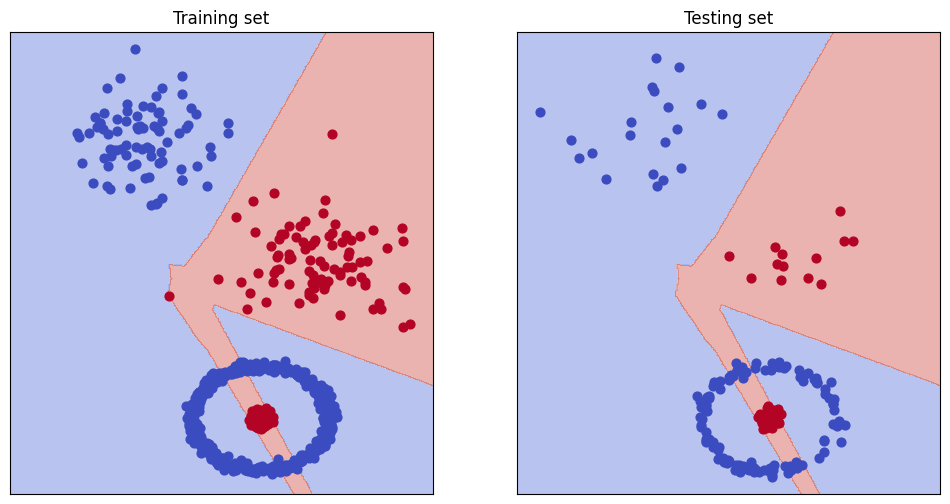

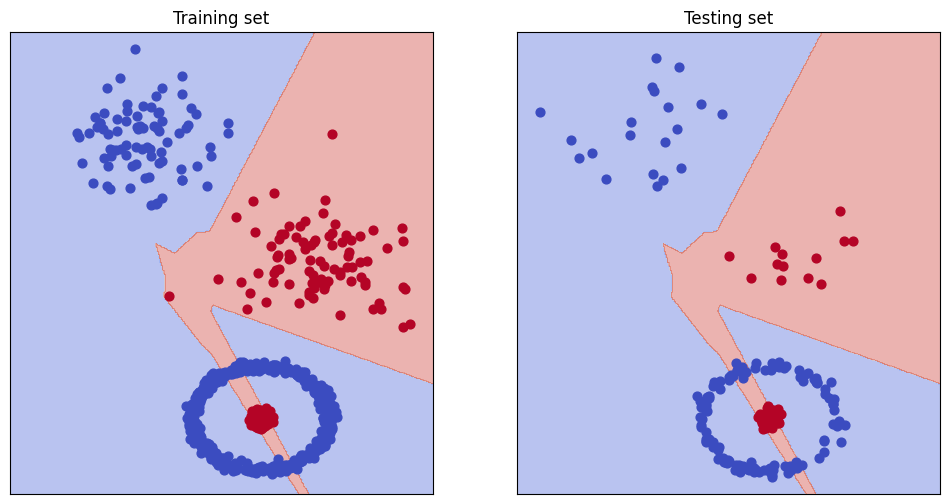

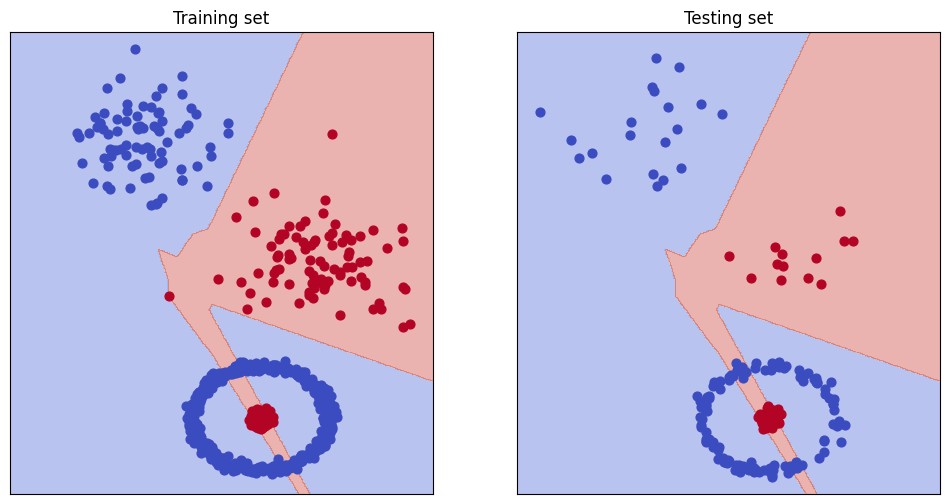

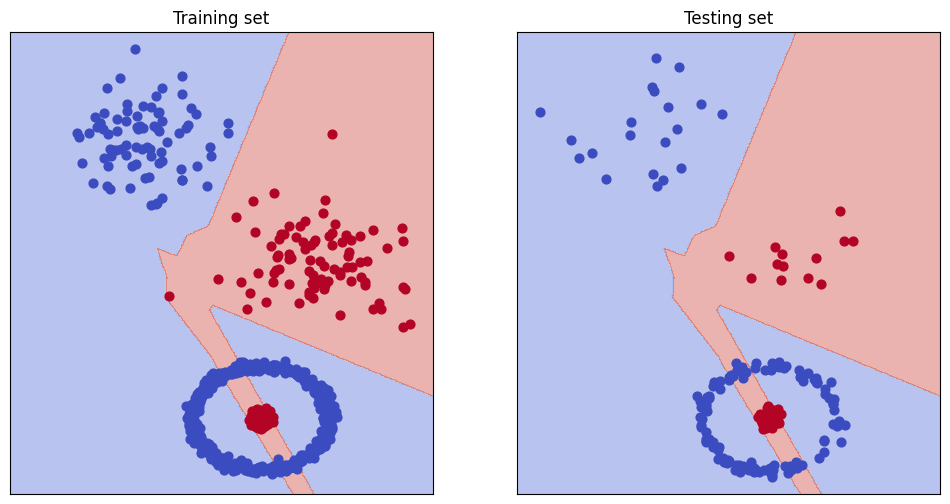

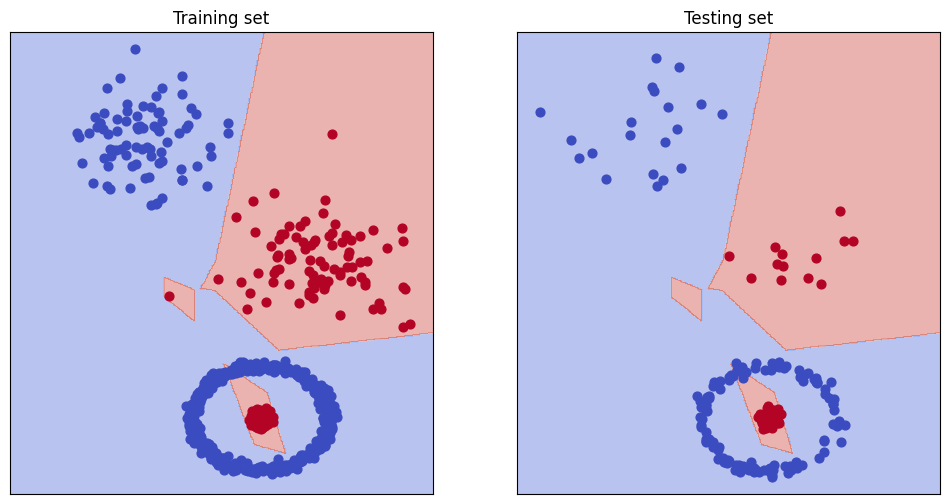

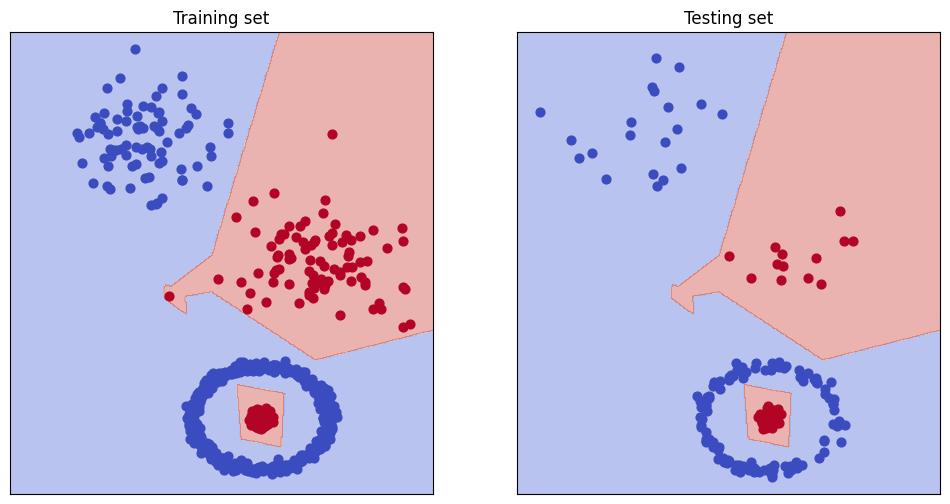

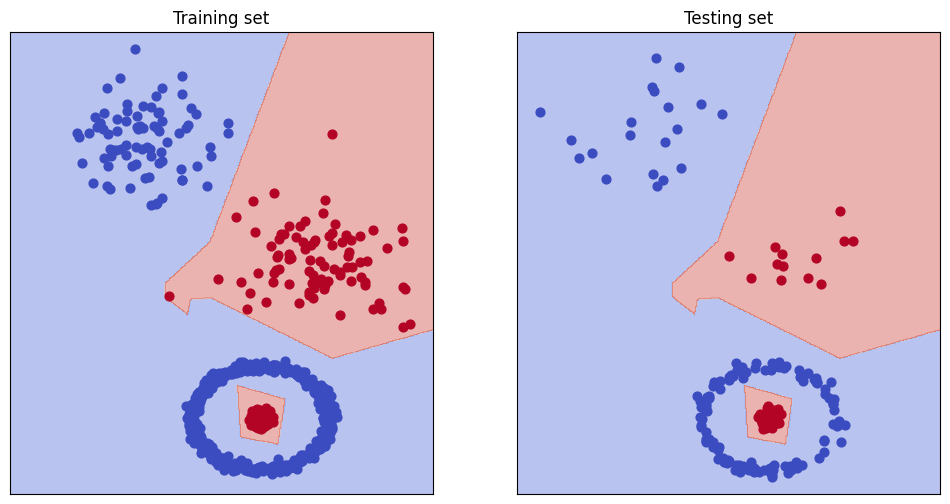

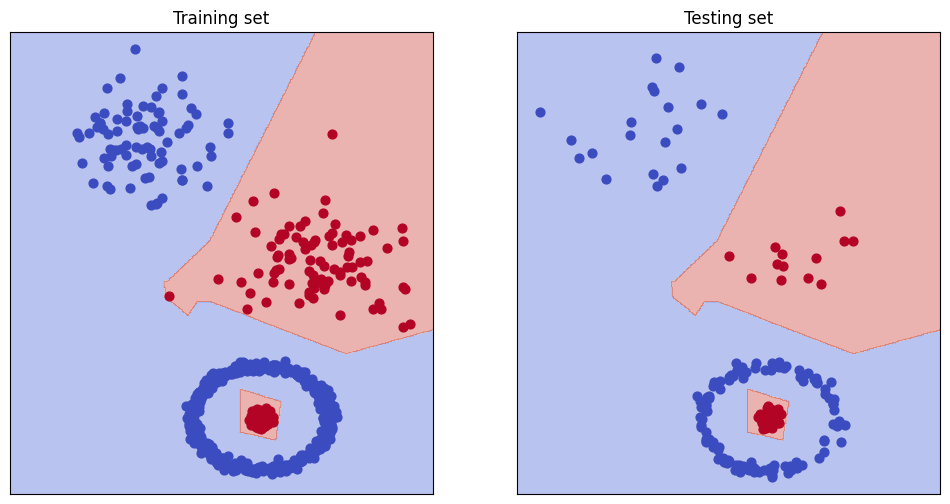

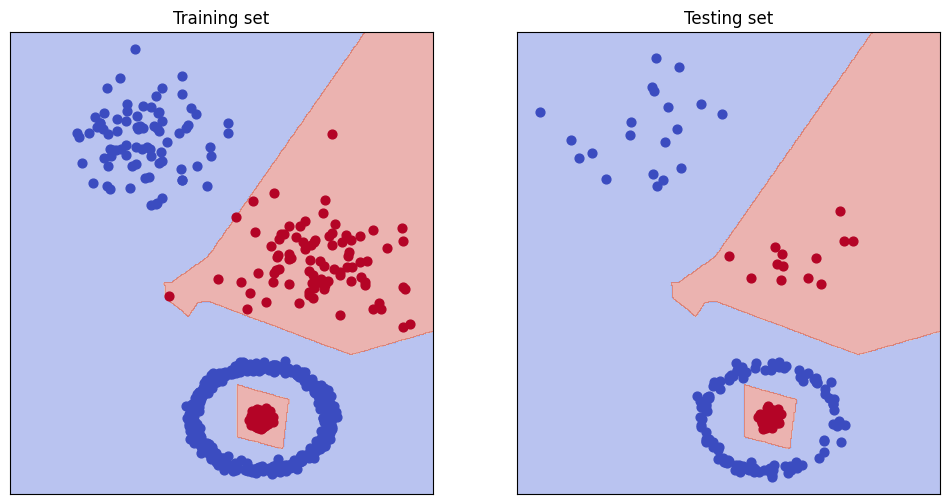

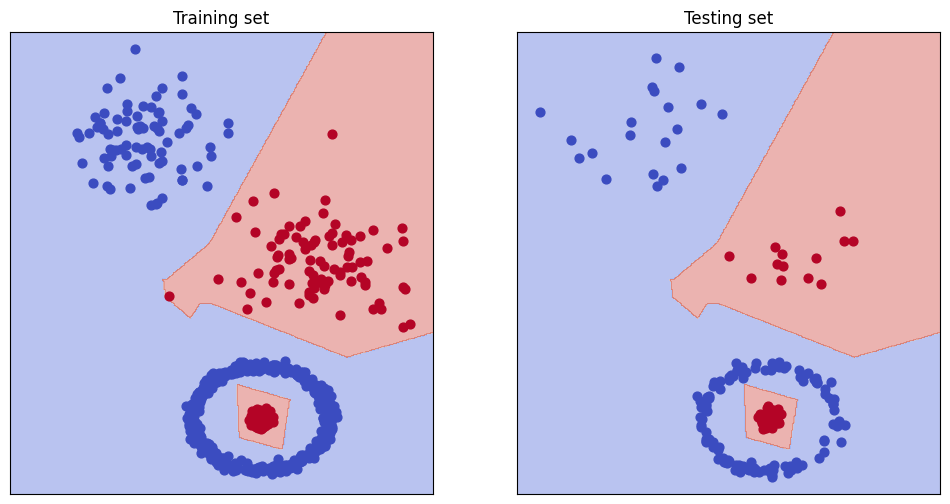

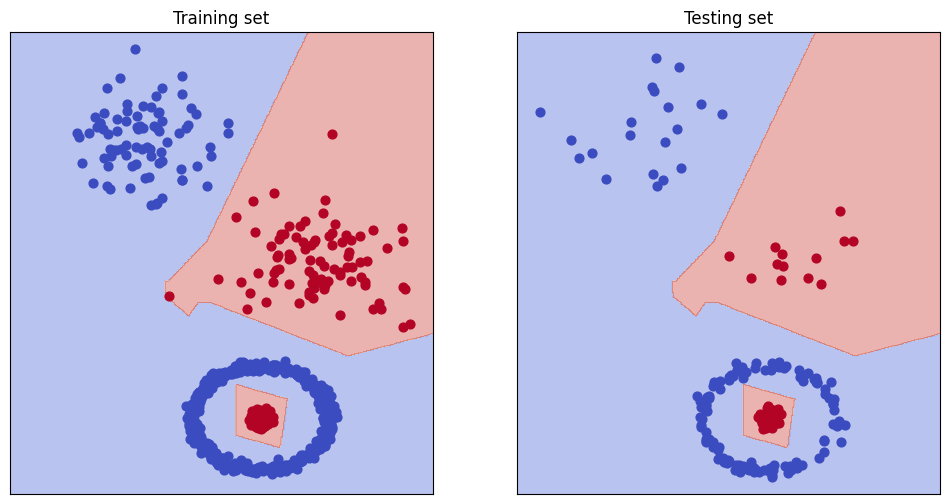

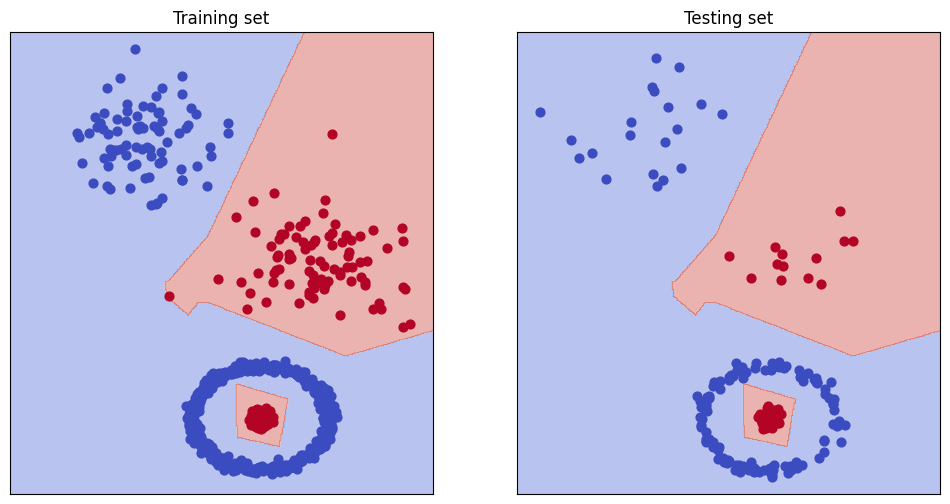

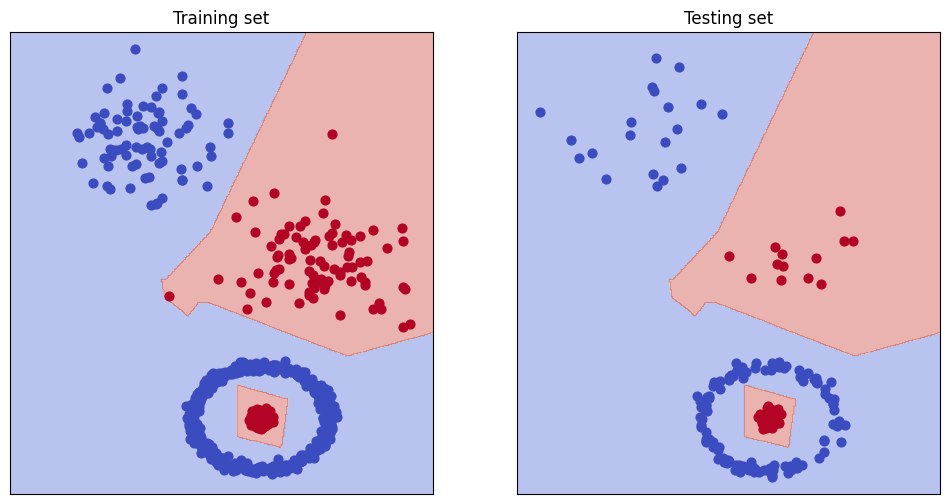

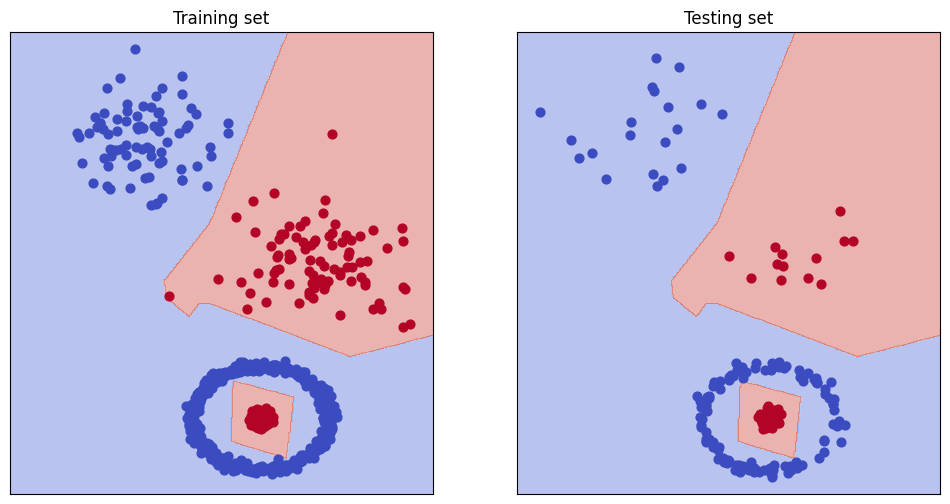

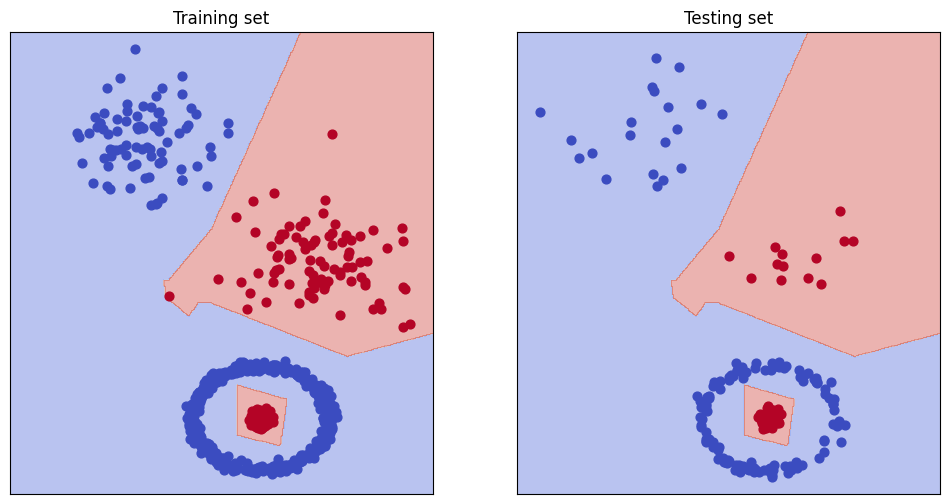

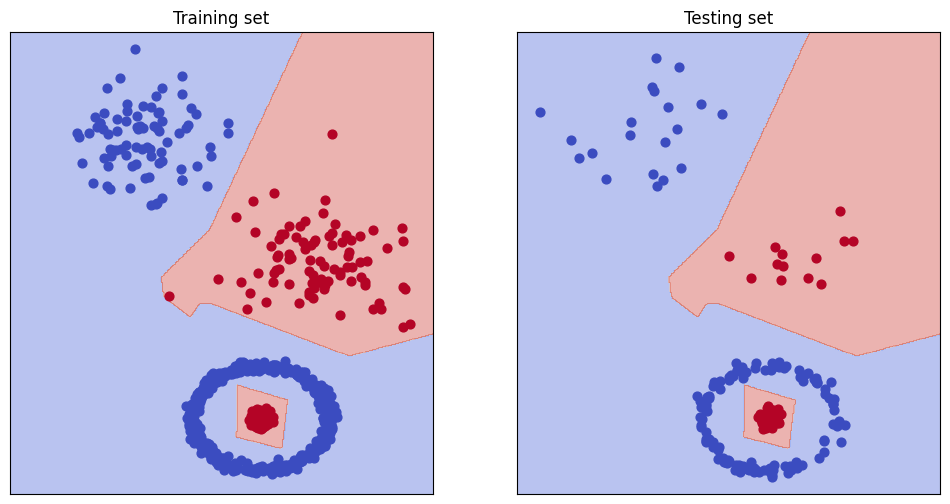

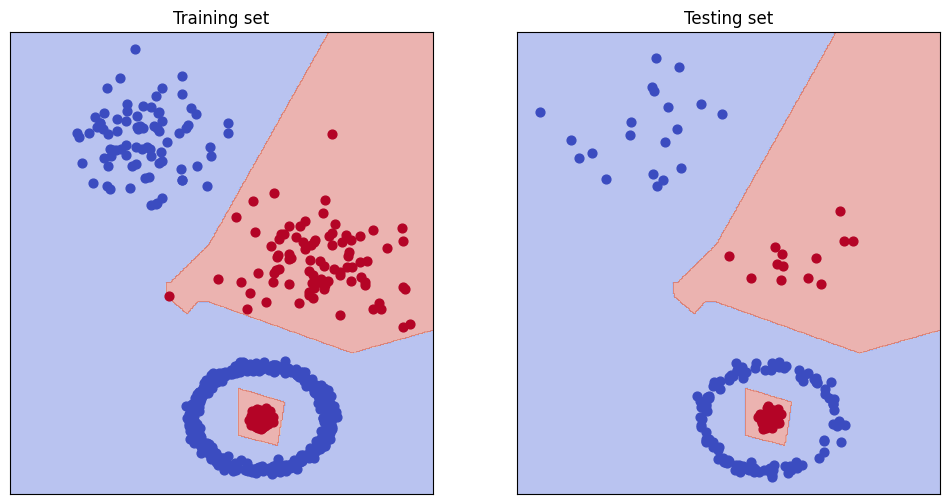

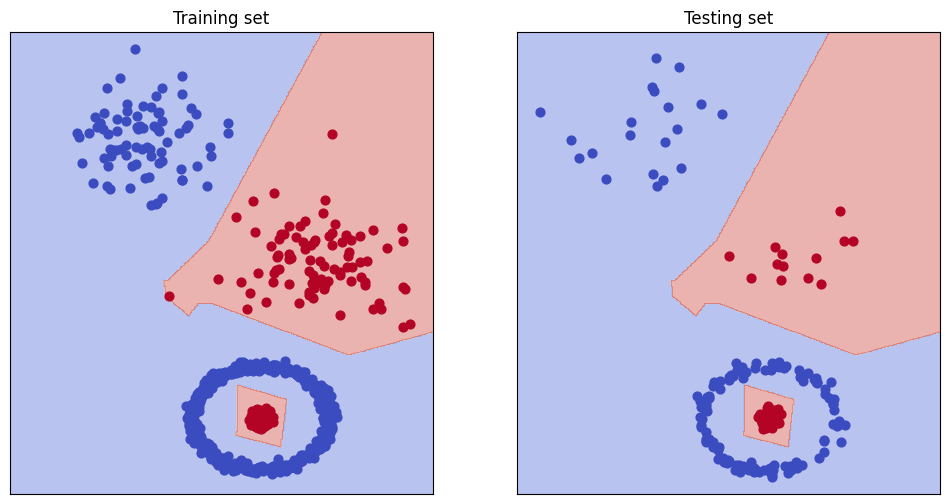

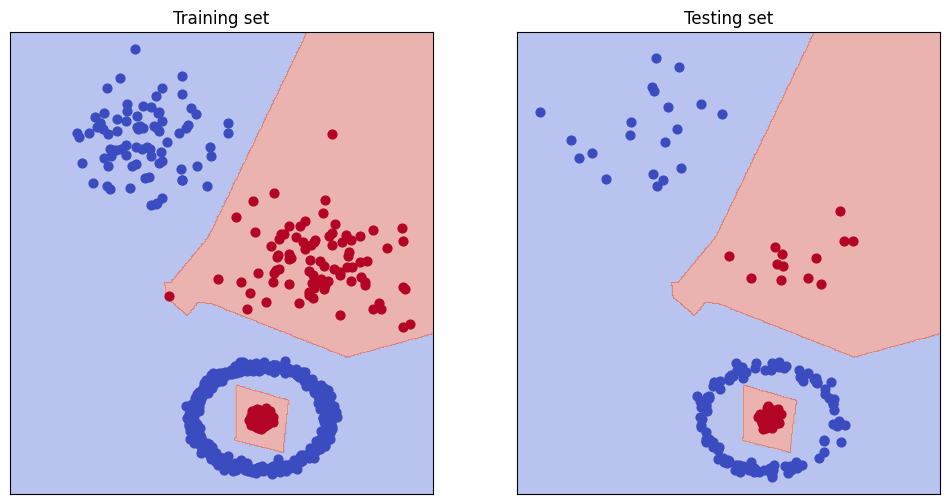

In [ ]:
for j in range(len(predictions)):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  # Plot filled contours using points in plot_mesh
  ax1.contourf(xx, yy, predictions[j], cmap='coolwarm', alpha=0.4)
  ax2.contourf(xx, yy, predictions[j], cmap='coolwarm', alpha=0.4)

  for i in np.unique(y_train):
    ix = np.where(y_train == i)
    ax1.scatter(X_train[ix,0], X_train[ix,1], marker='o', s=40, color=plot_colors[i])

  for i in np.unique(y_test):
    ix = np.where(y_test == i)
    ax2.scatter(X_test[ix,0], X_test[ix,1], marker='o', s=40, color=plot_colors[i])

  ax1.set_title('Training set')
  ax1.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False);
  ax1.set(xlabel=None, ylabel=None)
  ax2.set_title('Testing set')
  ax2.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False);
  ax2.set(xlabel=None, ylabel=None)

  plt.show()

## Plotting responses from neurons

In [ ]:
# get the weights and biases from the linear layer
fc1_weights = model.fc1.weight.detach()
fc1_bias = model.fc1.bias.detach()

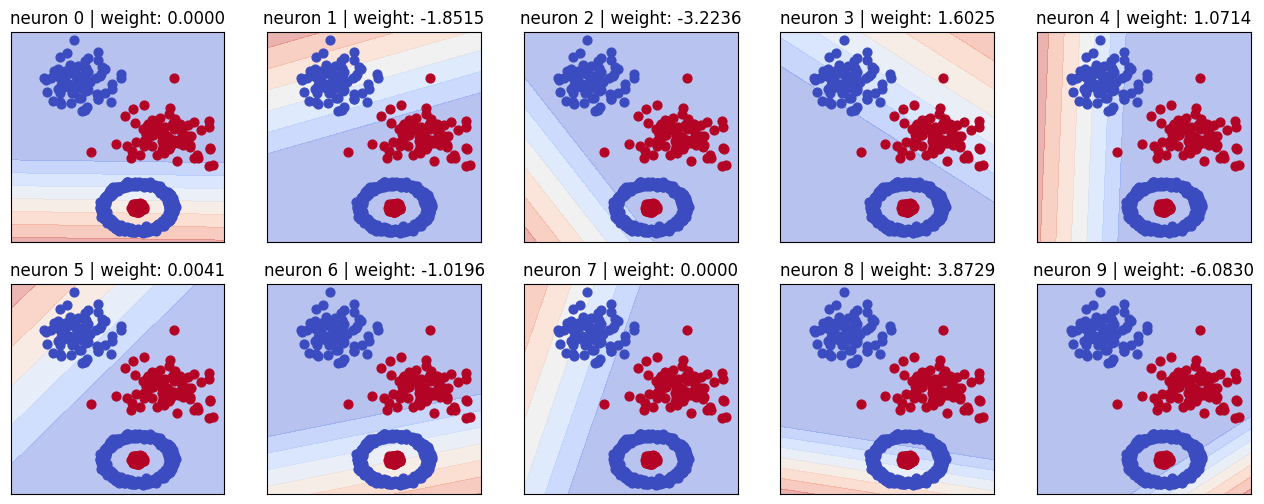

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(16, 6))
for j, ax in enumerate(fig.axes):

  z = F.relu((plot_mesh @ fc1_weights[j,:]) + fc1_bias[j])
  z = z.reshape(xx.shape).detach().numpy()
  fc2_weights = model.fc2.weight.detach().numpy()

  ax.contourf(xx, yy, z, cmap='coolwarm', alpha=0.4)

  for i in np.unique(y_train):
    ix = np.where(y_train == i)
    ax.scatter(X_train[ix,0], X_train[ix,1], marker='o', s=40, color=plot_colors[i])

  ax.set_title(f'neuron {j} | weight: {fc2_weights[0,j]:.4f}')
  ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labeltop=False,labelleft=False,labelright=False);
  ax.set(xlabel=None, ylabel=None)